In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import shutil

# There are Two parts in this notebook: 1. find and move groups to new folders, and 2. splitting data into train val test sets

# 1. Find similar images and group them

In [2]:
resnet18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])
resnet = torch.nn.Sequential(*list(resnet18.children())[:-1])
resnet.to('cuda');

In [3]:
def euclidean_distance(output1, output2):
    return torch.sqrt(torch.sum((output1 - output2) ** 2))

def cosine_sim(output1, output2):
    output1 = output1.view(-1)
    output2 = output2.view(-1)
    return F.cosine_similarity(output1.unsqueeze(0), output2.unsqueeze(0))

In [99]:
class bballDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image
    

class SingleImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = Image.open(self.image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

def extract_features(model, target_image_path, other_image_path, batch_size=256, transform=transform, other_image_vecs=None):
    # Check if target_image_path is a directory or a single file
    if os.path.isdir(target_image_path):
        target_dataset = bballDataset(target_image_path, transform=transform)
    else:
        target_dataset = SingleImageDataset(target_image_path, transform=transform)

    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    other_image_dataset = bballDataset(other_image_path, transform=transform)
    other_image_loader = DataLoader(other_image_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    target_vecs = []
    other_image_vecs = [] if other_image_vecs is None else other_image_vecs

    model = model.eval().to('cuda')
    with torch.no_grad():
        print("Extracting target image features...")
        for data in tqdm(target_loader):
            data = data.to('cuda')
            output = model(data)
            output = output.view(output.size(0), -1)
            target_vecs.append(output)

        if not other_image_vecs:
            print("Extracting other image features...") 
            for data in tqdm(other_image_loader):
                data = data.to('cuda')
                output = model(data)
                output = output.view(output.size(0), -1)
                other_image_vecs.append(output)
            
    target_vecs = torch.cat(target_vecs, dim=0)
    other_image_vecs = torch.cat(other_image_vecs, dim=0) 
    
    return target_vecs, other_image_vecs

    
    
def find_similar_images(target_vecs, other_image_vecs, other_image_path, threshold=0.9):
    other_image_names = os.listdir(other_image_path)
    target_vecs_expanded = target_vecs.unsqueeze(0)  # Shape: [1980, 1, 512]
    other_image_vecs_expanded = other_image_vecs.unsqueeze(1)  # Shape: [1, 190, 512]
    
    cos_similarities = F.cosine_similarity(target_vecs_expanded, other_image_vecs_expanded, dim=2)  # Shape: [1980, 190]
    average_similarities = cos_similarities.mean(dim=1)  # Shape: [1980]
    print(average_similarities.shape)
    
    high_similarities = np.argwhere(average_similarities.cpu().numpy() > threshold).flatten()
    similar_image_paths = [os.path.join(other_image_path, other_image_names[i]) for i in high_similarities]
    similarities = average_similarities.cpu().numpy()[high_similarities]
    
    
    return similar_image_paths, similarities

In [105]:
target_img_path = "basketballDetection-24/train/images/000000023_jpg.rf.103829b72bc6329467b2b81a2a1d081e.jpg"
other_img_path = "basketballDetection-24/train/images/"

batch_size = 512

target_vecs, other_image_vecs = extract_features(resnet, 
                                                    target_img_path, 
                                                    other_img_path, 
                                                    batch_size=batch_size, 
                                                    transform=transform,
                                                )

Extracting target image features...


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Extracting other image features...


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


In [111]:
similar_images, average_similarities = find_similar_images(target_vecs, other_image_vecs, other_img_path, threshold=0.83)
len(similar_images)

torch.Size([1373])


32

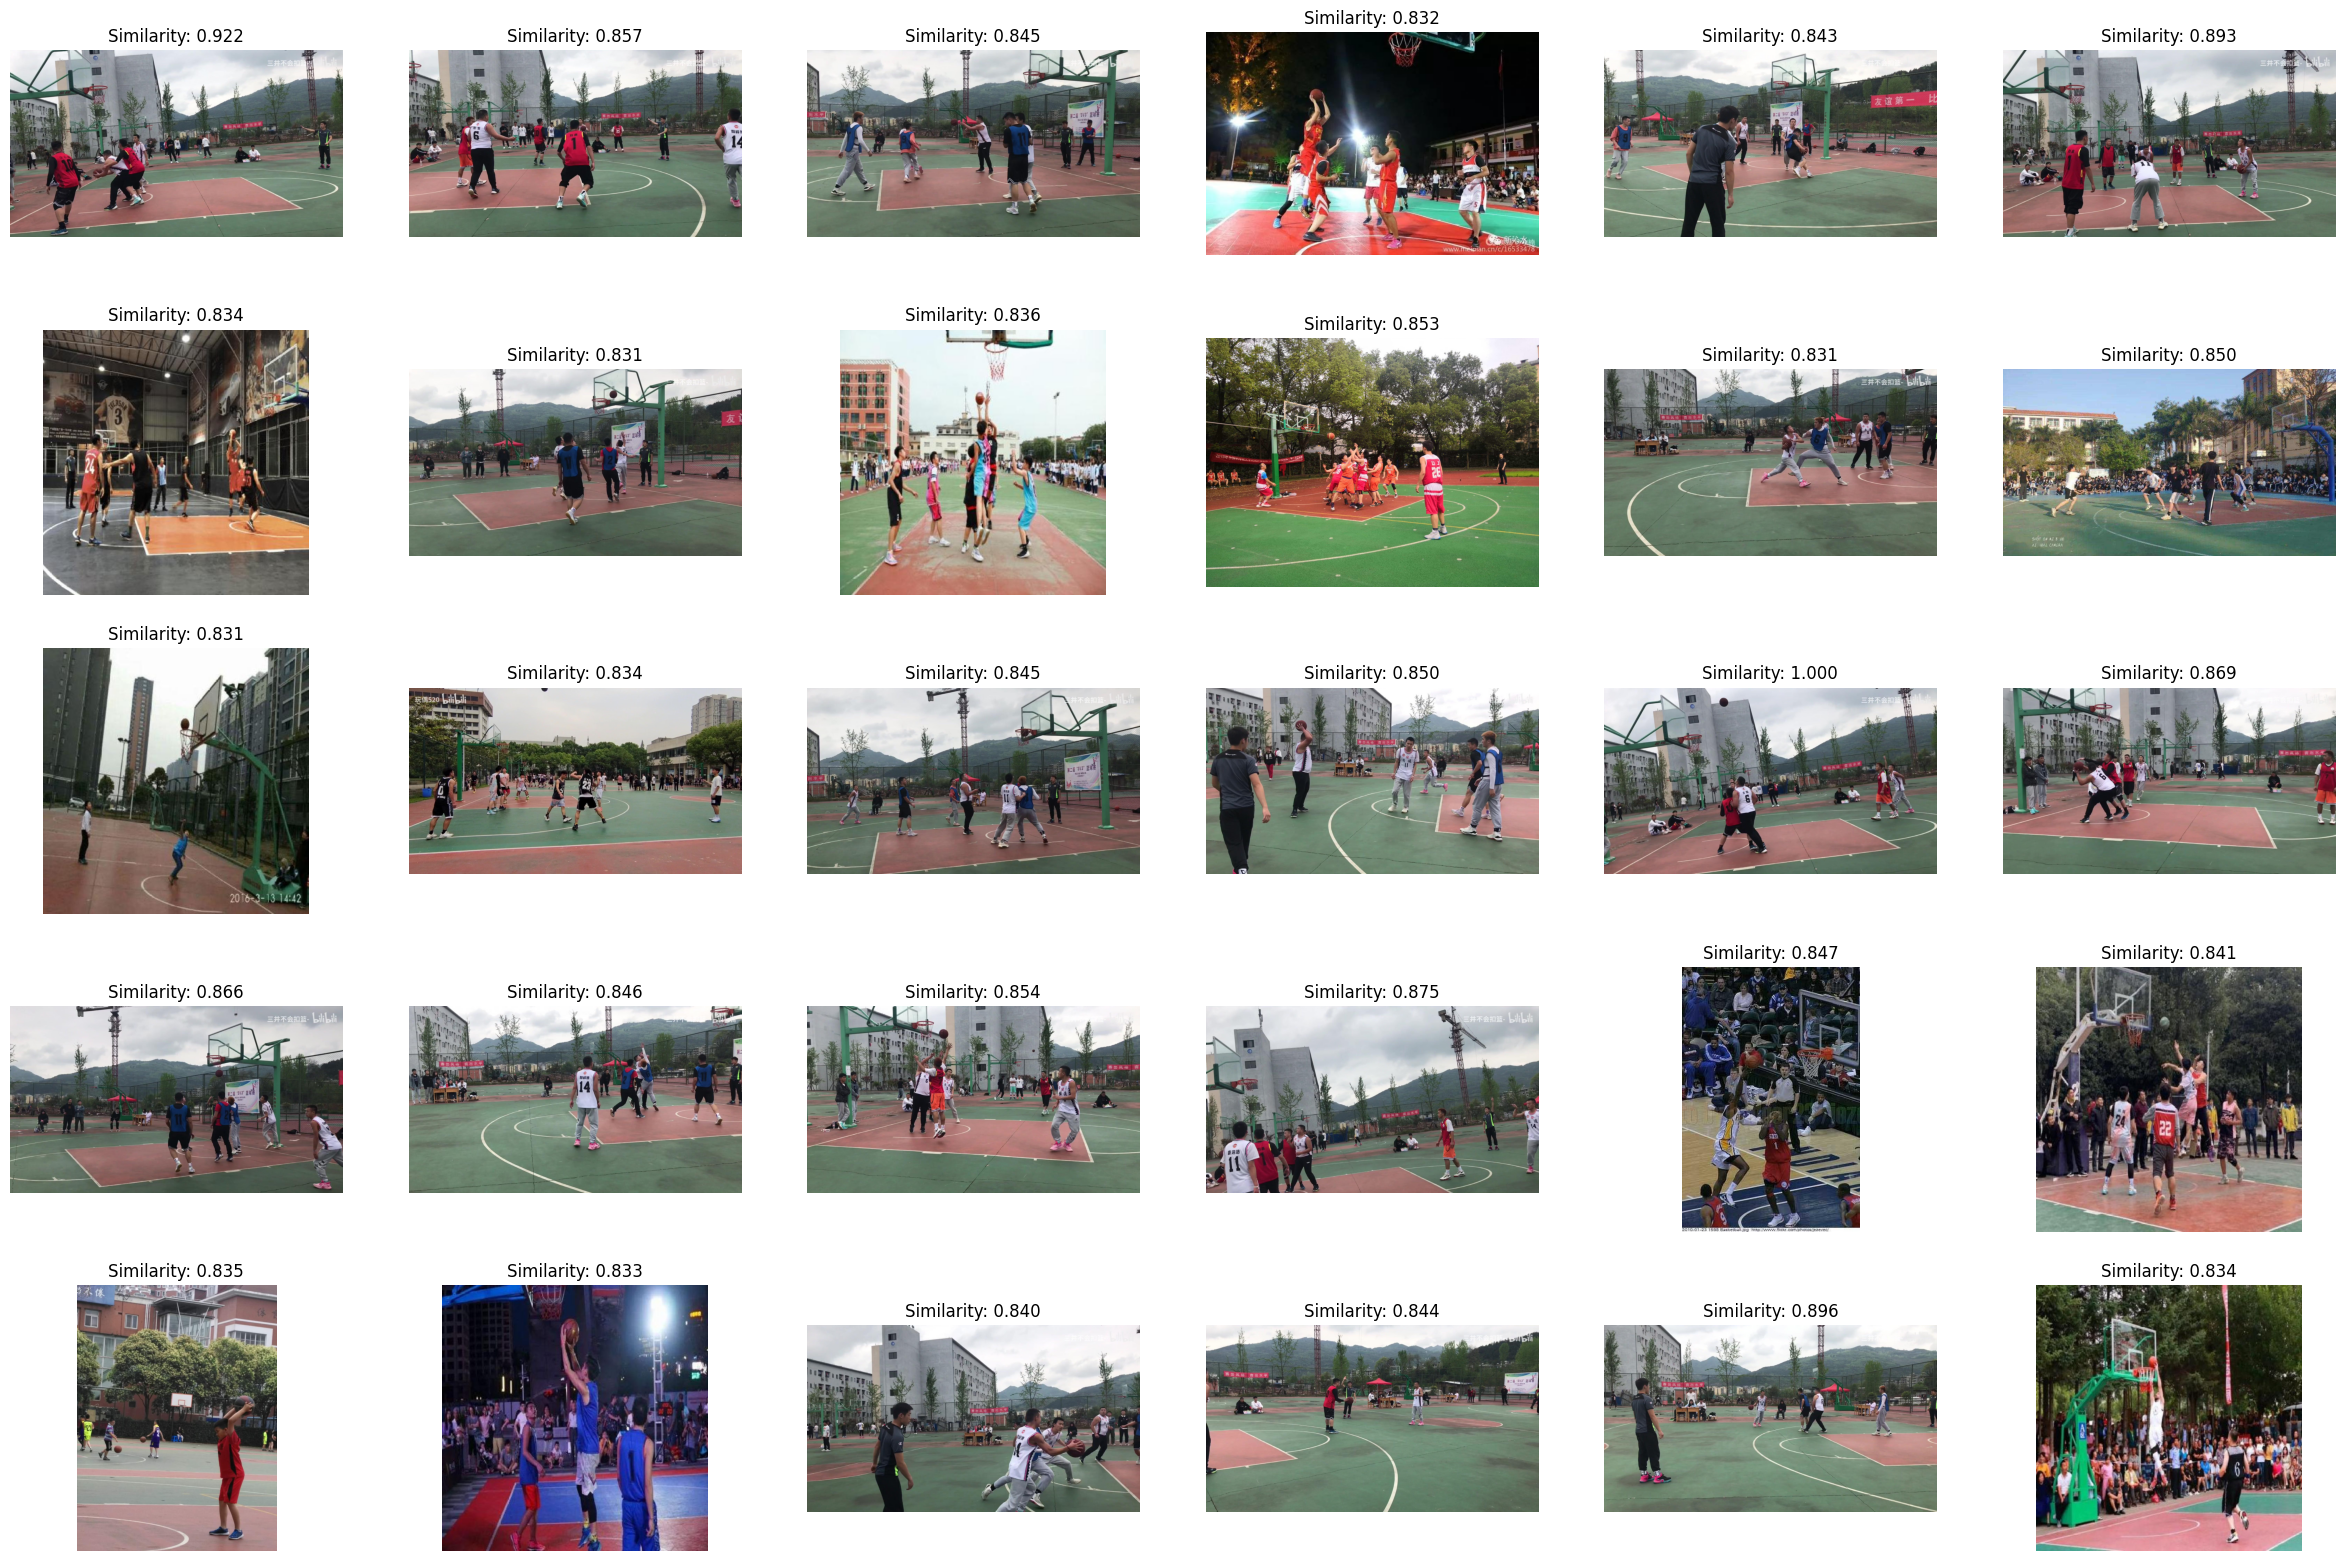

In [112]:
fig, axes = plt.subplots(int(len(similar_images) ** 0.5), 1 + int(len(similar_images) ** 0.5), figsize=(30, 20))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(Image.open(similar_images[i]))
    ax.set_title(f"Similarity: {average_similarities[i]:.3f}")
    ax.axis('off')

In [60]:
# calculate each image in other_image_vecs with the rest of the images in other_image_vecs
possible_duplicates = []
for i in range(other_image_vecs.shape[0]):
    target = other_image_vecs[i]
    cosine_similarities = F.cosine_similarity(target.unsqueeze(0), other_image_vecs, dim=1)
    cosine_similarities[i] = 0
    high_similarities = np.argwhere(cosine_similarities.cpu().numpy() > 0.95).flatten()
    if high_similarities:
        possible_duplicates.append((i, high_similarities, cosine_similarities.cpu().numpy()[high_similarities]))
    

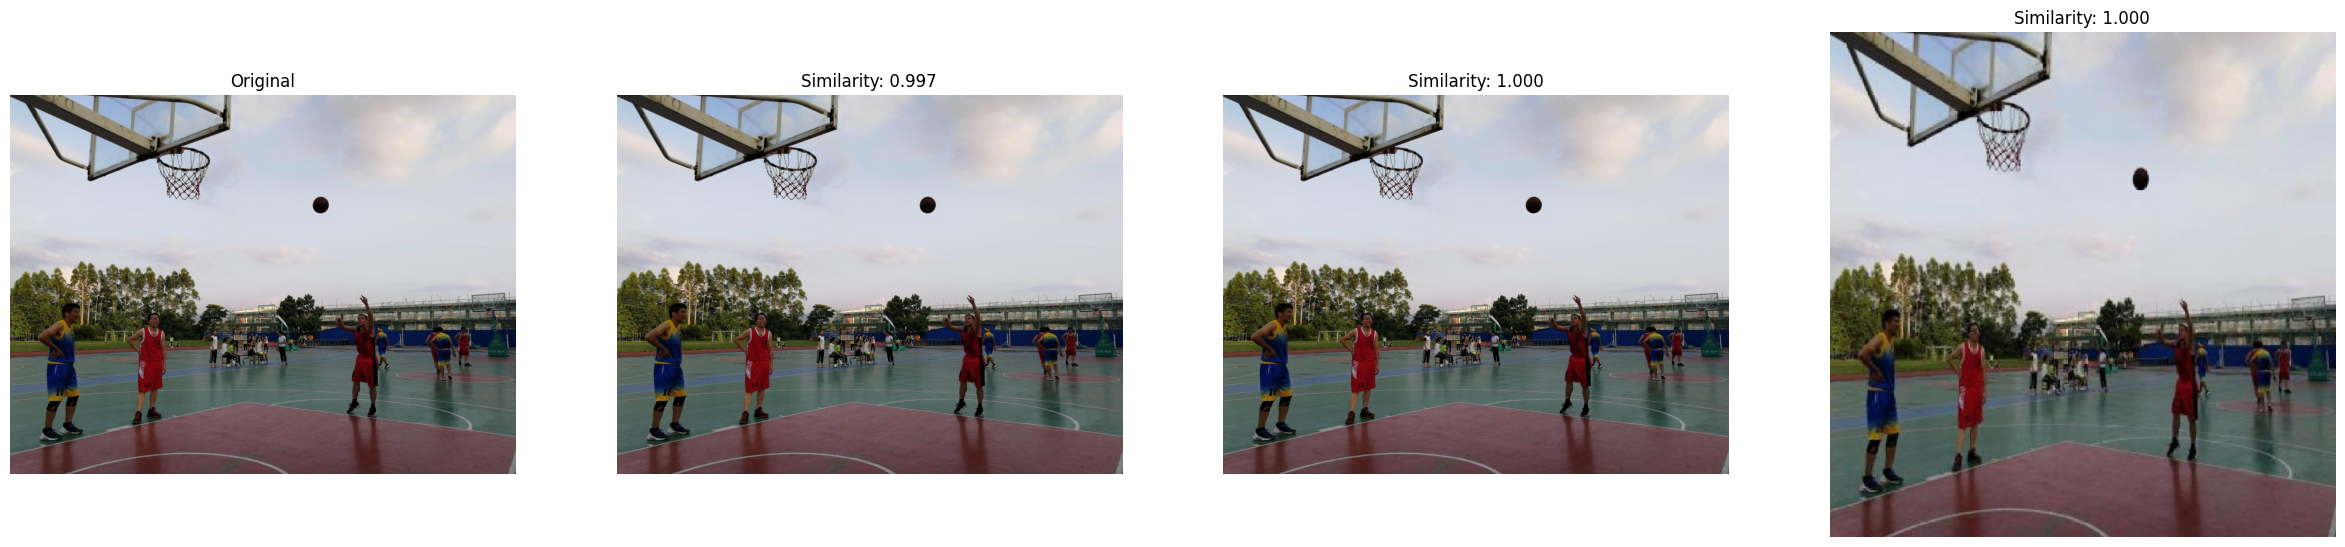

In [47]:
pair = [x for x in possible_duplicates if x[0] == 587][0]
original_img_index = pair[0]
similar_img_indices = pair[1]
similar_img_paths = [os.path.join(other_img_path, os.listdir(other_img_path)[i]) for i in similar_img_indices]
similarities = pair[2]

fig, axes = plt.subplots(1, len(similar_img_paths) + 1, figsize=(30, 10))
axes[0].imshow(Image.open(os.path.join(other_img_path, os.listdir(other_img_path)[original_img_index])))
axes[0].set_title("Original")
axes[0].axis('off')

for i, ax in enumerate(axes[1:]):
    
    ax.imshow(Image.open(similar_img_paths[i]))
    ax.set_title(f"Similarity: {similarities[i-1]:.3f}")
    ax.axis('off')

In [49]:
keep = []
discard = []
for dup in possible_duplicates:
    img = dup[0]
    duplicates = dup[1]
    if img not in discard:
        keep.append(img)
        discard.extend(duplicates)

In [54]:
discard = list(set(discard))
discard_paths = [os.path.join(other_img_path, os.listdir(other_img_path)[i]) for i in discard]

for path in discard_paths:
    shutil.move(path, "temp")

In [95]:
possible_groups = []
for i in range(other_image_vecs.shape[0]):
    target = other_image_vecs[i]
    cosine_similarities = F.cosine_similarity(target.unsqueeze(0), other_image_vecs, dim=1)
    cosine_similarities[i] = 0
    high_similarities = np.argwhere(cosine_similarities.cpu().numpy() > 0.93).flatten()
    if high_similarities.size > 0 and i not in possible_groups:
        group = [i] + high_similarities.tolist()
        possible_groups.append((group, [0] + cosine_similarities.cpu().numpy()[high_similarities].tolist()))
        
 

In [96]:
possible_groups

[([4, 217], [0, 0.9581075310707092]),
 ([16, 183], [0, 0.9400164484977722]),
 ([26, 830, 1310, 1339],
  [0, 0.9399136304855347, 0.9376940727233887, 0.9449800252914429]),
 ([29, 54], [0, 0.9568467736244202]),
 ([34, 59, 466, 848, 1158, 1345],
  [0,
   0.9552712440490723,
   0.9430043697357178,
   0.9445422887802124,
   0.9636081457138062,
   0.9431709051132202]),
 ([54, 29], [0, 0.9568467736244202]),
 ([55, 949, 1144], [0, 0.9558576941490173, 0.9361934065818787]),
 ([59, 34, 384, 466, 491, 848, 996, 1017, 1102, 1130, 1158, 1208, 1230, 1345],
  [0,
   0.9552712440490723,
   0.9408838748931885,
   0.9537148475646973,
   0.9542886018753052,
   0.9621350765228271,
   0.9519050121307373,
   0.939409077167511,
   0.9443977475166321,
   0.9437288641929626,
   0.972472071647644,
   0.9571573734283447,
   0.9442867040634155,
   0.9899832606315613]),
 ([63, 692], [0, 0.9793703556060791]),
 ([74, 540, 626], [0, 0.9714563488960266, 0.974000096321106]),
 ([85, 1072], [0, 0.9649257063865662]),
 ([95,

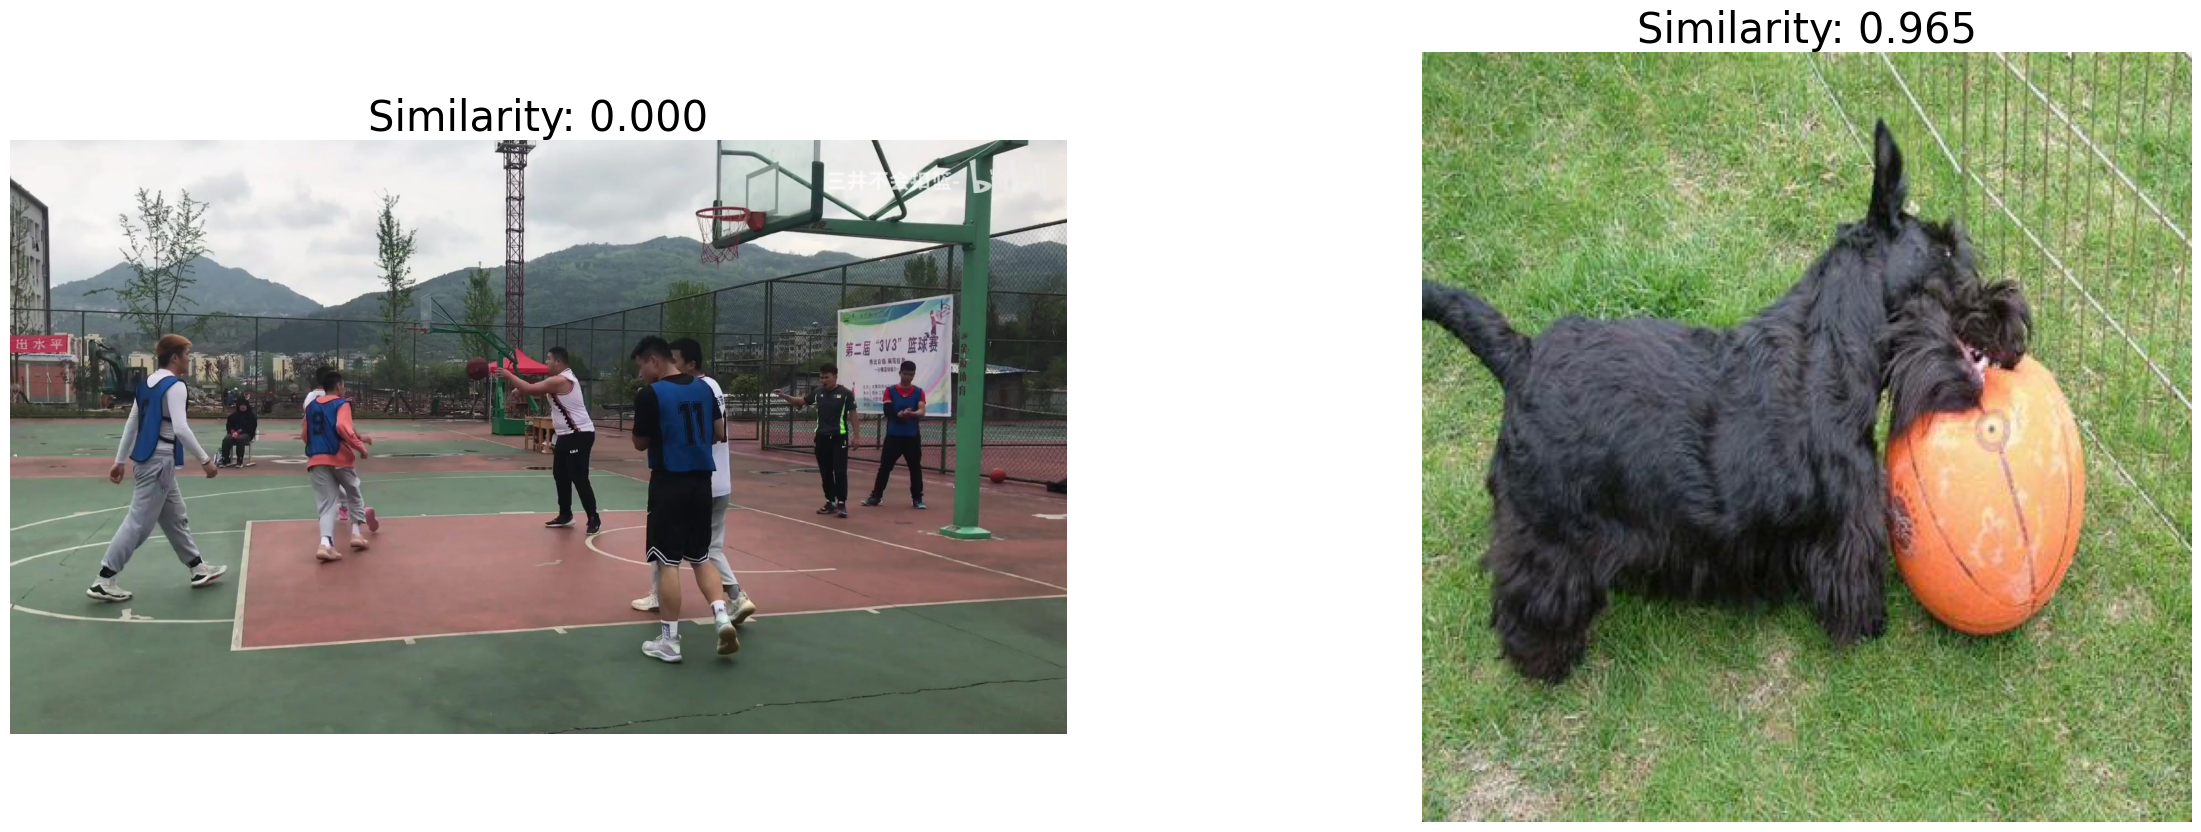

In [98]:
group = possible_groups[10]

fig, axes = plt.subplots(1, len(group[0]), figsize=(30, 10))
for i, ax in enumerate(axes):
    ax.imshow(Image.open(os.path.join(other_img_path, os.listdir(other_img_path)[group[0][i]])))
    ax.set_title(f"Similarity: {group[1][i]:.3f}", fontdict={'fontsize': 30})
    ax.axis('off')

In [91]:
group_path = [os.path.join(other_img_path, os.listdir(other_img_path)[i]) for i in group[0]]
for g in group_path:
    os.remove(g)

In [113]:
for img in os.listdir("basketballDetection-24/train/images"):
    shutil.move(os.path.join("basketballDetection-24/train/images", img), "detection_dataset_groupby_env/other")

In [116]:
labels_root_dir = "basketballDetection-24/train/labels"
root_dir = "detection_dataset_groupby_env"
for env in os.listdir(root_dir):
    # make "image" and "label" directories
    if not os.path.exists(os.path.join(root_dir, env, "images")):
        os.mkdir(os.path.join(root_dir, env, "images"))
    if not os.path.exists(os.path.join(root_dir, env, "labels")):
        os.mkdir(os.path.join(root_dir, env, "labels"))
    
    # move images and labels to their respective directories
    for img in os.listdir(os.path.join(root_dir, env)):
        # check if img is the "images" or "labels" directory
        if img == "images" or img == "labels":
            continue
        shutil.move(os.path.join(root_dir, env, img), os.path.join(root_dir, env, "images"))
        label_file_path = os.path.join(labels_root_dir, img.replace(".jpg", ".txt"))
        shutil.move(label_file_path, os.path.join(root_dir, env, "labels"))
        
        

In [35]:
# verify that all images have a label file
for env in os.listdir(root_dir):
    for img in os.listdir(os.path.join(root_dir, env, "images")):
        label_file_path = os.path.join(root_dir, env, "labels", img.replace(".jpg", ".txt"))
        if not os.path.exists(label_file_path):
            print(label_file_path)

# 2. split data

In [9]:
# import packages to split dataset into train and test and val
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tqdm import tqdm   

In [10]:
root_dir = "detection_dataset_groupby_env"
envs = os.listdir(root_dir)
envs.remove("other")
# chekc length of each env
for env in envs:
    print(env, len(os.listdir(os.path.join(root_dir, env, "images"))))
    

mima 563
group_3 240
philipine_night 63
group_2 73
group_1 31
korean_outdoor 236
korean_organized 128
group_4 7


In [29]:
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
envs_shuffled = np.random.permutation(envs)
train_envs, val_envs, test_envs = np.split(envs_shuffled, [int(train_ratio * len(envs)), int((train_ratio + val_ratio) * len(envs))])


select_n_from_each_env = 30

env_train_set = []
env_val_set = []
env_test_set = []


for env, env_name in zip([train_envs, val_envs, test_envs], [env_train_set, env_val_set, env_test_set]):
    for env in env:
        n = select_n_from_each_env if len(os.listdir(os.path.join(root_dir, env, "images"))) >= select_n_from_each_env else len(os.listdir(os.path.join(root_dir, env, "images")))
        selected_images = np.random.choice(os.listdir(os.path.join(root_dir, env, "images")), size=n, replace=False).tolist()
        selected_images = [os.path.join(root_dir, env, "images", img) for img in selected_images]
        env_name.extend(selected_images)

In [30]:
train_envs, val_envs

(array(['group_4', 'korean_organized', 'mima', 'korean_outdoor', 'group_3'],
       dtype='<U16'),
 array(['philipine_night', 'group_2'], dtype='<U16'))

In [31]:
print(len(env_train_set), len(env_val_set), len(env_test_set))

127 60 30


In [32]:
other_images = os.listdir(os.path.join(root_dir, "other", "images"))
other_train_set, other_val_set = train_test_split(other_images, test_size=0.3, random_state=42) 
other_val_set, other_test_set = train_test_split(other_val_set, test_size=0.5, random_state=42)
other_train_set = [os.path.join(root_dir, "other", "images", img) for img in other_train_set]
other_val_set = [os.path.join(root_dir, "other", "images", img) for img in other_val_set]
other_test_set = [os.path.join(root_dir, "other", "images", img) for img in other_test_set]

print(len(other_train_set), len(other_val_set), len(other_test_set))

961 206 207


In [33]:
all_train_set = env_train_set + other_train_set
all_val_set = env_val_set + other_val_set
all_test_set = env_test_set + other_test_set

print(len(all_train_set), len(all_val_set), len(all_test_set))

1088 266 237


In [42]:
dirs = ["train", "valid", "test"]
dataset_root_dir = "basketballDetection-24"
for dir, dataset in zip(dirs, [all_train_set, all_val_set, all_test_set]):
    if not os.path.exists(os.path.join(dataset_root_dir, dir)):
        os.mkdir(os.path.join(dataset_root_dir, dir))
        
        os.mkdir(os.path.join(dataset_root_dir, dir, "images"))
        os.mkdir(os.path.join(dataset_root_dir, dir, "labels"))
    print(f"Copying {dir} dataset...")
    for img in tqdm(dataset):
        try:
            shutil.copy(img, os.path.join(dataset_root_dir, dir, "images"))
        except Exception as e:
            print(e)
            break
        
        
        try:
            shutil.copy(img.replace("images", "labels").replace(".jpg", ".txt"), os.path.join(dataset_root_dir, dir, "labels"))
        except Exception as e:
            print(e)
            break

Copying train dataset...


100%|██████████| 1088/1088 [00:24<00:00, 44.14it/s] 


Copying valid dataset...


100%|██████████| 266/266 [00:01<00:00, 201.77it/s]


Copying test dataset...


100%|██████████| 237/237 [00:00<00:00, 336.37it/s]

[Errno 2] No such file or directory: 'detection_dataset_groupby_env/other/images/labels'
[Errno 2] No such file or directory: 'detection_dataset_groupby_env/other/labels/labels'


In [43]:
# verify new dir lengths
for dir in dirs:
    print(dir, len(os.listdir(os.path.join(dataset_root_dir, dir, "images"))))

train 1088
valid 266
test 236
